# Assignment 1 – Glacier Mass Balance Model

Let's go!

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import rasterio as rio
import matplotlib.colors
from matplotlib.patches import Patch
import re

# Nr 1 – calculate the mass balance 1980-2009

---------- RESULTS ----------
Glacier volume loss: 758622626.648 [m3]
Glacier mass loss: 644829232650.757 [kg]
Average glacier surface 1980-2009: 35253750.0 [m2]
Glacier ablation in m w.e. y-1: 0.631 [m w.e. y-1]
------------------------------


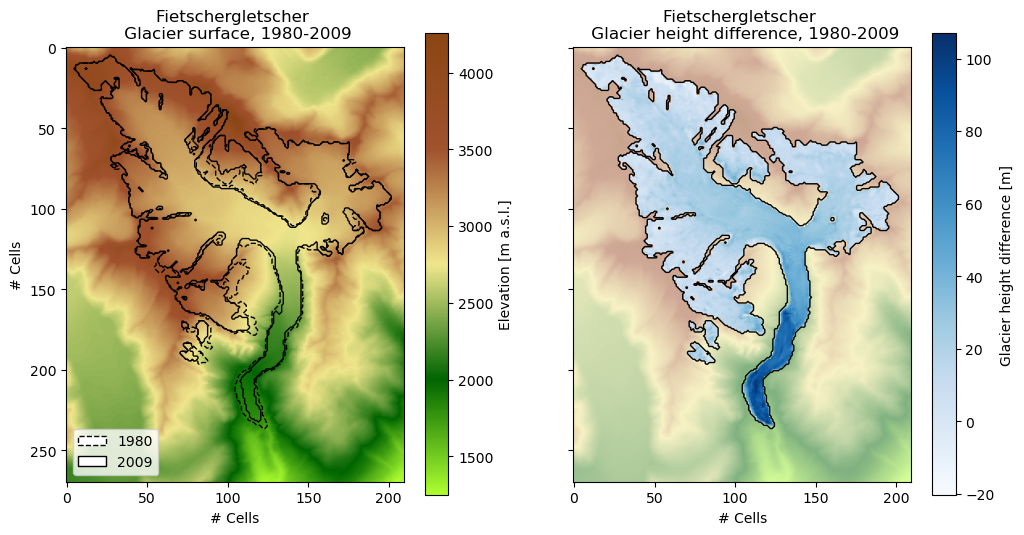

In [26]:
# Plot rasters and masks
with rio.open('data_raw/dem_fiescher_1980.asc') as src1:
    dem_1980 = src1.read(1)

with rio.open('data_raw/dem_fiescher_2009.asc') as src2:
    dem_2009 = src2.read(1)

with rio.open('data_raw/glacier_mask_fiescher_1980.asc') as src3:
    mask_1980 = src3.read(1)

with rio.open('data_raw/glacier_mask_fiescher_2009.asc') as src4:
    mask_2009 = src4.read(1)

# Compute resolution
transform = src1.transform

# Get the resolution in the X and Y directions
resolution_x = transform.a
resolution_y = transform.e

# Compute glacier DEMs
glacier_dem_1980 = dem_1980 * mask_1980
glacier_dem_2009 = dem_2009 * mask_1980
glacier_vertical_change = glacier_dem_1980 - glacier_dem_2009

# Computer glacier ablation
rho = 850 # kgm-3
cell_surface = abs(resolution_x * resolution_y)
glacier_volume_loss = glacier_vertical_change.sum() * cell_surface # m3
glacier_mass_loss = glacier_volume_loss * rho # kg
average_cells_number = (mask_1980.sum() + mask_2009.sum()) / 2
average_glacier_surface = average_cells_number * cell_surface # m2
glacier_water_equivalent_loss = glacier_mass_loss / average_cells_number / cell_surface / 1000 / (2009-1980)

print("-"*10, "RESULTS", "-"*10)
print("Glacier volume loss:", round(glacier_volume_loss, 3), "[m3]")
print("Glacier mass loss:", round(glacier_mass_loss, 3), "[kg]")
print("Average glacier surface 1980-2009:", round(average_glacier_surface, 3), "[m2]")
print("Glacier ablation in m w.e. y-1:", round(glacier_water_equivalent_loss, 3), "[m w.e. y-1]")
print("-"*30)

# Plot DEMs and masks
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
cmap_terrain = matplotlib.colors.LinearSegmentedColormap.from_list("", ["greenyellow", "darkgreen", "khaki", "sienna", "saddlebrown"])
im1 = ax1.imshow(dem_1980, cmap=cmap_terrain)
ax1.contour(mask_1980, levels=[0.5], colors='black', linestyles='--', linewidths=1)
ax1.contour(mask_2009, levels=[0.5], colors='black', linestyles='solid', linewidths=1)
ax2.imshow(dem_1980, cmap=cmap_terrain, alpha=0.5)
glacier_vertical_change[glacier_vertical_change == 0] = np.nan
im2 = ax2.imshow(glacier_vertical_change, cmap="Blues")
ax2.contour(mask_1980, levels=[0.5], colors='black', linestyles='solid', linewidths=1)
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical', label="Elevation [m a.s.l.]")
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', label="Glacier height difference [m]")
handles = [Patch(facecolor="white", edgecolor="k", linestyle="--", label="1980"), 
          Patch(facecolor="white", edgecolor="k", linestyle="-", label="2009")]
ax1.legend(handles=handles, loc="lower left")
ax1.set_ylabel("# Cells")
ax1.set_xlabel("# Cells")
ax2.set_xlabel("# Cells")
ax1.set_title("Fietschergletscher \n Glacier surface, 1980-2009")
ax2.set_title("Fietschergletscher \n Glacier height difference, 1980-2009")
plt.savefig("plots/glacier_mass_balance_part_1.png", dpi=300)
plt.show()

In [27]:
glacier_mass_loss

644829232650.7568

**Question 1 [6 pts]: How large was the specific mass change rate experienced by the glacier
during the period?**

*Express your result in units of ”m water equivalent per year” (m w.e. a−1), and make sure to
explain what assumptions you did for computing this number.
Hint: For converting from kg to mw.e. you can consider the average glacier surface for the two
given years.*





# Nr 2 - choose and read in climate data

Station: 
 - Grimsel Hospiz (1980 MSL)
 - how high is Fieschergletscher?
 
Norm value charts for Precipitation:
 - Precip 61-90, precip 91-20 and sunshine 91-20
 - Yellow left Jungfraujoch, yellow right Grimsel, orange ~ location of Fieschergletscher
 - Glacier in the area with highest precipitation of switzerland, not entirely represented by either of the stations
 - Grimsel in data_raw folder
 - URL for data: https://www.meteoswiss.admin.ch/services-and-publications/applications/ext/climate-tables-homogenized.html 
 - URL if you want to look at more norm value maps: https://www.meteoswiss.admin.ch/services-and-publications/applications/ext/climate-norm-maps-public.html
 
<div>
<img src="maps/precip_61-90.png" width="700" align="left"/>
<img src="maps/precip_91-20.png" width="400" align="left"/>
<img src="maps/sunshine_91-20.png" width="400" align="left"/>
</div>
 
 

**Question 2 [5 pts]: Which data did you chose and why?**
*Make sure to state the url from which you downloaded the data, and to discuss the choice of
the station that you selected.*

We used homogeneous monthly temperature and precipitation data from MeteoSwiss (which can be found here: https://www.meteoswiss.admin.ch/services-and-publications/applications/ext/climate-tables-homogenized.html), as MeteoSwiss provides the official long-time station records for Switzerland. 

For Fieschergletscher, we considered the three closest stations: Jungfraujoch at 3571 MSL, Grimsel Hospiz (GRH) at 1980 MSL and Meiringen at 589 MSL. All stations go back further than 1935. However, only Grimsel Hospiz and Meiringen combine temperature and precipitation data, while Jungfraujoch provides only temperature. Therefore, the record would have to be combined with precipitation data from another station – which would lead to new uncertainties, taking into account elevation differences and how much precipitation varies even at small spatial scales.

Of the two remaining stations, we chose Grimsel Hospiz. The station is substantially closer to the glacier than Meiringen and unlike Meiringen at a similar elevation level as the Fieschergletscher. Moreover, it is the only station in the area with a similar yearly amount of precipitation as the glacier.

In [28]:
GRH = pd.read_csv("data_raw/climate_GRH_data.txt", sep='\s+')

GRH

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5527/1136363557.py:1: SyntaxWarning: invalid escape sequence '\s'
  GRH = pd.read_csv("data_raw/climate_GRH_data.txt", sep='\s+')


,Year,Month,Temperature,Precipitation
0,1932,1,-2.8,216.8
1,1932,2,-9.0,24.6
2,1932,3,-5.2,169.0
3,1932,4,-3.2,137.0
4,1932,5,2.0,164.7
...,...,...,...,...
1096,2023,5,5.0,128.4
1097,2023,6,10.7,72.1
1098,2023,7,11.6,102.1
1099,2023,8,11.3,196.7


# Nr 3 – Calibrate a TI model

Use the meteorological time series retrieved in Question 2 to calibrate the Degree Day Factor
(DDF) of a simple temperature index model. For this task, you can make the following assumptions:

- Precipitation can be modelled with a ”block rain model” (see lecture notes) and the time series retrieved in Question 2.
- Snow and rain can be distinguished through a threshold temperature of T0 = 2 ◦C.
- The temperature at any elevation can be computed from the data retrieved in Task 2 and by using a temperature lapse rate of dT/dz = 6.5 ◦Ckm−1.
- Melt occurs for temperatures above 0 ◦C.
- Every month has 365/12 ≈ 30.42 days.
- The provided DEMs both refer to October.
- The glacier surface can be described with the DEM of 2009 and does not change in time.

TI-Model Review: https://www.sciencedirect.com/science/article/abs/pii/S0022169403002579?via%3Dihub 

In [29]:
mb = -0.5 # m w.e./a, replace with actual value


# annual_ablation = DDF ((T1 + 0.0065*delta_h)>0 +  T2...+T12)
# area constant, not necessary for ablation (if constant elevation is assumed)

# for glacier elevation = mean elevation 
# more accurate: calculate percentage of glacier area above/below 0
# assumed difference between mean glacier elevation and station: Glacier is 100 m higher
# delta_T = Temperature difference that needs to be substracted from T for equal elevation glacier

delta_T = 0.0065*100
GRH_processed = GRH.copy()
GRH_processed["T_glacier"] = GRH_processed["Temperature"] - delta_T


# dataframe with only rows that are months between 1980 and 2009 above 0 °C
GRH_processed = GRH_processed[(GRH_processed.T_glacier >= 0)]
GRH_processed = GRH_processed[(GRH_processed.Year >= 1980)]
GRH_processed = GRH_processed[(GRH_processed.Year <= 2009)]

# calculate days per year that count into melting season
GRH_processed["n_months"] = 1
GRH_processed = GRH_processed.groupby("Year").sum()
GRH_processed["melt_days"] = GRH_processed["n_months"] * 30.42

GRH_processed


# total ablation per year = DDF * melt_days * T_glacier = ((DDF*30.42*T1) + (DDF*30.42*T2) + ...)

# Version 1: assume flexible mass balances 1980-2009
# --> 1 DDF for all years
# 30*mb = sum(accumulation1980-2009) - DDF * sum(melt_days*T_glacier 1980-2009) 

# Version 2: assume same mass balance for every year 1980-2009
# --> different DDF for all years
# calculation for every year:
# mb = annual_accumulation - DDF * melt_days * T_glacier

# check in Literature whether version 1 or 2 is preferred!


,Month,Temperature,Precipitation,T_glacier,n_months,melt_days
Year,,,,,,
1980,45,30.8,887.2,26.90,6,182.52
1981,49,34.0,1180.6,29.45,7,212.94
1982,45,40.2,774.3,36.30,6,182.52
1983,56,43.8,827.7,39.25,7,212.94
1984,51,32.8,675.6,28.90,6,182.52
1985,45,43.3,600.4,39.40,6,182.52
1986,45,41.1,635.5,37.20,6,182.52
1987,40,37.6,749.1,34.35,5,152.10
1988,49,45.3,826.9,40.75,7,212.94


In [30]:
for year in GRH_processed["Year"]:
    if year in range(1980,2010):
        print(year)

KeyError: 'Year'

**Question 3.1 [7 pts]: What was your procedure to calibrate the DDF?**
*Make sure to provide a step by step explanation and to mention any assumption.*

- concerning Hint 3: while TI models work robust at big scales (e.g. entire catchment), they miss local effects and varying melt rates that can be caused by different exposure to radiation/differences in debris cover of different parts of the glacier

**Question 3.2 [6 pts]: What value (and unit) do you obtain for the calibrated DDF, and how
does it compare to values reported in the literature?**
*Make sure to have ”days” somewhere in the units for the ”Degree Day Factor”, and compare
your result against at least two published DDF values (provide the corresponding references).
Discuss what might be at the origin of the differences that you find (if any).*

- Value from assignment sheet: DDF = 5 mmw.e. (◦Cd)−1.

**Question 3.3 [6 pts]: Reflect upon the various assumptions that were necessary for the calibration.**
*Which assumptions are likely to introduce a bias? In what direction do the individual
biases go, and which assumption are likely to introduce the largest biases?*

- if Nov-Apr main accumulation season and May-Sep main ablation season (what about October?): 
-> Summer is one day longer than model calculation, winter one day shorter. 


- **Hint 1:** What you want is to choose a DDF such that the model reproduces the total glacier mass change that you determined in Question 1.
- **Hint 2:** You can perform your computations at monthly resolution.
- **Hint 3:** Reflect whether you want to consider a distributed modelling approach (i.e. if you want to consider every grid-cell of the glacier separately) or not (e.g. if you only want to consider the mean glacier elevation, for example). Make sure to discuss this point in Question 3.1.

In [116]:
# Read climate data
grh = pd.read_csv("data_raw/climate_GRH_data.txt", sep="\s+")
grh.index = pd.to_datetime(grh["Year"].astype(str) + '-' + grh['Month'].astype(str).str.zfill(2), format='%Y-%m')
grh = grh.drop(columns=["Year", "Month"])
grh = grh.loc[(grh.index >= "1980-10-01") & (grh.index <= "2009-10-01")]

# Read raster data
with rio.open('data_raw/dem_fiescher_1980.asc') as src1:
    dem_1980 = src1.read(1)

with rio.open('data_raw/dem_fiescher_2009.asc') as src2:
    dem_2009 = src2.read(1)

with rio.open('data_raw/glacier_mask_fiescher_1980.asc') as src3:
    mask_1980 = src3.read(1)

with rio.open('data_raw/glacier_mask_fiescher_2009.asc') as src4:
    mask_2009 = src4.read(1)


# Define parameters for temperature grid calculation 
elevation_grh = 1980 # m 
dt_dz = -6.5/1000 # °C/m
rain_snow_thresh = 2 # °C
melt_thresh = 0 # °C

# Compute DEM with temperature difference between glacier and station
# (assignment says that the glacier should be described with dem_2009 for this)
dem_elev_diff = dem_2009 - elevation_grh
dem_temp_diff = dem_elev_diff * dt_dz # °C

empty_df = []

for datetime in grh.index:
    # print("Processing", datetime)
    # Creating temperature DEMs for land and glacier
    temp_grh = float(grh["Temperature"].loc[grh.index == datetime])
    dem_temp = (dem_temp_diff + temp_grh) * mask_2009
    dem_snow = np.where(dem_temp <= rain_snow_thresh, 1, 0)
    cells_snow = dem_snow.sum()
    dem_melt = np.where(dem_temp > melt_thresh, 1, 0)
    cells_melt = dem_snow.sum()
    empty_df.append([datetime, dem_temp, dem_snow, cells_snow, cells_melt])

df = pd.DataFrame(empty_df)
df.columns = ["datetime", "temperature", "snow", "cells_with_snow", "cells_with_melt"]
df = df.set_index("datetime")
df

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5527/410967200.py:2: SyntaxWarning: invalid escape sequence '\s'
  grh = pd.read_csv("data_raw/climate_GRH_data.txt", sep="\s+")
/tmp/ipykernel_5527/410967200.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  temp_grh = float(grh["Temperature"].loc[grh.index == datetime])


,temperature,snow,cells_with_snow,cells_with_melt
datetime,,,,
1980-10-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",56470,56470
1980-11-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",56700,56700
1980-12-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",56700,56700
1981-01-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",56700,56700
1981-02-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",56700,56700
...,...,...,...,...
2009-06-01,"[[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",54374,54374
2009-07-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",48907,48907
2009-08-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",45017,45017


<Axes: xlabel='datetime'>

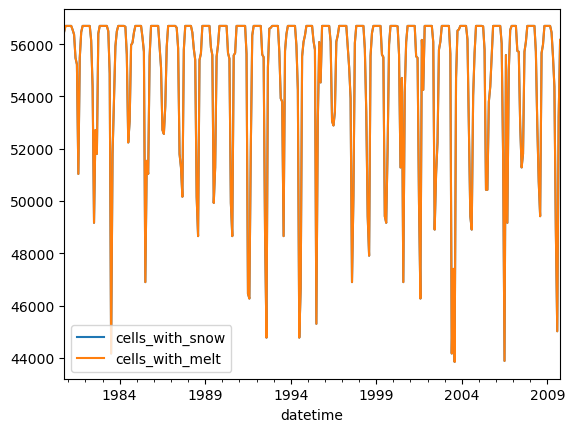

In [117]:
df[["cells_with_snow", "cells_with_melt"]].plot()

# Nr 4 – Mass balance reconstruction

Use the model calibrated in Task 3 and the same meteorological time series as above to reconstruct
the annual mass balance of the glacier for the period 1935-2022. Express the results in
mw.e. a−1, and refer the annual values to the hydrological year (1 Oct. – 30 Sep.). Plot your
results.

**Question 4 [7 pts]: What are the (i) cumulative and (ii) average glacier mass balance (in
mw.e. and mw.e. a−1, respectively) and what do you observe in the yearly time series?**
*Check whether you can discern trends, and whether there are periods or individual years that
stand out. For this task, you can neglect any changes in glacier geometry.*

# Nr 5 – Future projection
Use volume-area scaling to estimate the volume of the glacier for the year 2009. Then use the
mass balance time series that you computed in Task 4 for computing the mass change until 2022.
For the future, assume that the glacier mass balance rate (in mw.e. a−1) will remain the same
as it was on average over the past 30 years (period 1992-2022).

**Question 5.1 [4 pts]: What was the glacier volume in 2009?**
*Express you results in km3.*

**Question 5.2 [6 pts]: Based on your projection, when (year) will the glacier have lost 50% of
the volume it had in 2009?**
*Use ”Hint 1” below, and discuss whether the resulting ”projection” is likely to be an under- or
overestimate, and why.*

**Question 5.3 [4 pts]: Can you think of a strategy that avoids the simplification given in
”Hint 1”?**
*Explain how you could avoid the assumption of a constant area, and what additional information,
tools, or methods (if any) you would need for that.*

- Hint 1: As a simplification, you can assume that the glacier area remains constant at the 2009 level.
- Hint 2: If you did not solve Task 4, you can use the time series in the file sample massbalance time series.txt.
- Hint 3: Pay attention to the units for the glacier mass balance rate and the glacier volume.
- Hint 4: If you need to convert glacier volume to mass, assume a mean glacier density of 900 kgm−3.